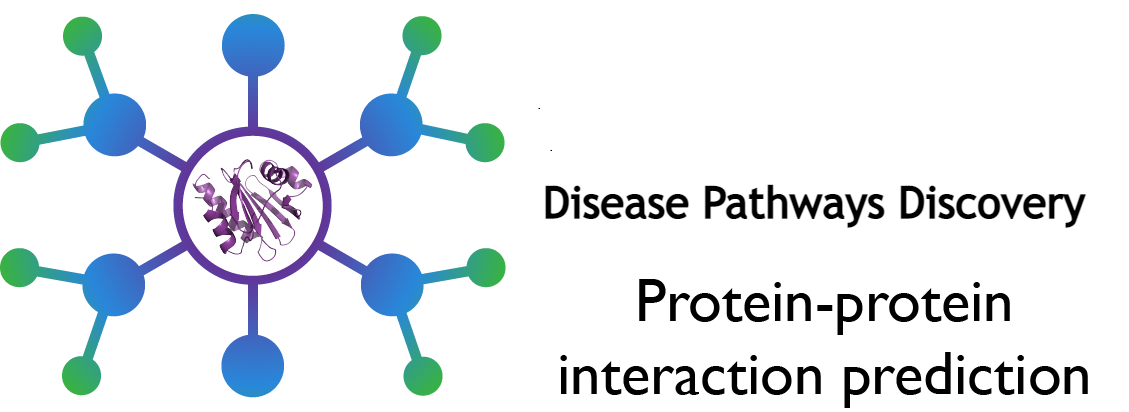

# Authors:

*   Hamza Azizi
*   Roua Acheche




# Protein Protein Interaction Prediction

In this notebook, we demonstrate the utility of deep learning methods for an important prediction problem on biological graphs. In particular, we consider the problem of predicting protein-protein interactions (PPIs).
One of the famous application fields is the Disease Pathways Discovery.
Which can be defined as sets of proteins associated with a given disease, is an important problem that has the potential to provide clinically actionable insights for disease diagnosis, prognosis, and treatment. Computational methods aid the discovery by relying on protein-protein interaction (PPI) networks.



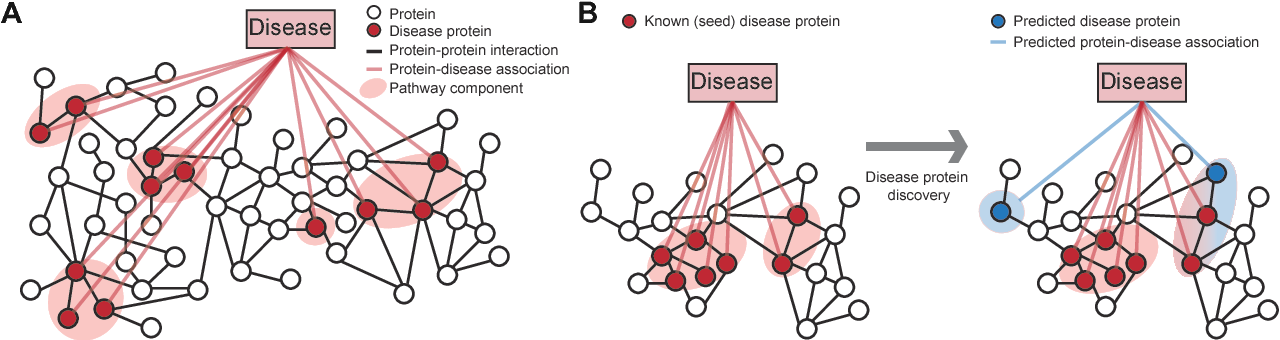

# The PP Pathways PPI Dataset
As a matter of fact the data set we dealing with is mainly made to discover Disease Pathways.
This dataset provided by [The SNAP library of Stanford University](https://snap.stanford.edu/biodata/datasets/10000/10000-PP-Pathways.html).
This is protein-protein interaction network that contains physical interactions between proteins that are experimentally documented in humans, such as metabolic enzyme-coupled interactions and signaling interactions. Nodes represent human proteins and edges represent physical interaction between proteins in a human cell.


Number of Nodes and Edges:

*   Nodes : 21557
*   Edges : 342353



# Link prediction with Graph Convolutional Networks

In this section, we use the implementation of the GCN algorithm provided by `stellargraph` and `tensorflow` to build a model that predicts protein interaction links in the PP Pathways PPI Dataset. The problem is treated as a supervised link prediction problem on physical interactions between proteins.
To address this problem, we build a model with the following architecture. First we build a three-layer GCN model that takes labeled node pairs (`Protein Source` -> `Protein Target`)  corresponding to possible interaction, and outputs a pair of node embeddings for the `Protein Source` and `Protein Target` nodes of the pair. These embeddings are then fed into a link classification layer, which first applies a binary operator to those node embeddings (e.g., concatenating them) to construct the embedding of the potential link. Thus obtained link embeddings are passed through the dense link classification layer to obtain link predictions - probability for these candidate links to actually exist in the network. The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy between predicted link probabilities and true link labels, with true/false interaction links having labels 1/0).

In [13]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 KB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.3/500.3 KB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.9 MB/s eta 0:00:00


In [14]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [15]:
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding
from stellargraph import StellarGraph
import pandas as pd
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
import numpy as np
from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

## Loading the PP-Pathwyas network data (EdgeList)

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In the dataset `df`, each row represents a link between nodes presenting proteins through indexes.

In [17]:
df = pd.read_csv("/content/gdrive/MyDrive/Link Prediction/PP-Pathways_ppi.csv", header = None)
df.columns = ["source","target"]
df

,source,target
0,1394,2778
1,6331,17999
2,122704,54460
3,2597,2911
4,4790,79155
...,...,...
342348,10969,4670
342349,6774,55748
342350,23299,399693
342351,9247,337967


`Feature Table` represents each protein node with attributes that will be used by the machine learning model to better identify links between nodes

In [ ]:
features = pd.read_csv("/content/gdrive/MyDrive/Link Prediction/bio-pathways-proteinmotifs.csv")
features

,Gene ID,Orbit Signature,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73
0,1,12,1925,65,1,228182,19497,280706,210,596,...,142,0,120,0,0,0,0,0,0,0
1,10,24,4723,259,17,453121,95381,2467189,1678,1249,...,279,244,1021,28,3,54,1,1,0,0
2,100,32,5186,478,18,585573,141129,1444972,4449,2201,...,656,454,22088,553,8,301,1,169,1,0
3,1000,78,11189,2790,213,1332626,694166,3827388,62206,10013,...,15341,9178,224983,17453,3911,5949,200,5929,552,96
4,10000,76,11270,2624,226,1542635,689984,1626042,55589,19746,...,42472,17290,25317,11970,2960,10240,366,1706,359,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22547,9991,18,6852,130,23,572038,89887,4310971,515,1606,...,834,310,56158,2282,40,229,0,724,14,3
22548,9992,3,142,2,1,19539,156,3992,0,7,...,0,0,0,0,0,0,0,0,0,0
22549,9993,8,999,28,0,117867,6815,87333,56,89,...,0,0,0,0,0,0,0,0,0,0
22550,9994,24,3779,227,49,450399,64316,542450,1197,986,...,474,932,2736,2742,253,477,7,299,71,18


In [ ]:
sources_and_targets = pd.concat([df.source, df.target])
nodes = pd.DataFrame(pd.unique(sources_and_targets), columns = ["Gene ID"])
nodes

,Gene ID
0,1394
1,6331
2,122704
3,2597
4,4790
...,...
21552,641340
21553,19400
21554,81918
21555,139378


In [ ]:
feature_table = features.merge(nodes)
feature_table

,Gene ID,Orbit Signature,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73
0,1,12,1925,65,1,228182,19497,280706,210,596,...,142,0,120,0,0,0,0,0,0,0
1,10,24,4723,259,17,453121,95381,2467189,1678,1249,...,279,244,1021,28,3,54,1,1,0,0
2,100,32,5186,478,18,585573,141129,1444972,4449,2201,...,656,454,22088,553,8,301,1,169,1,0
3,1000,78,11189,2790,213,1332626,694166,3827388,62206,10013,...,15341,9178,224983,17453,3911,5949,200,5929,552,96
4,10000,76,11270,2624,226,1542635,689984,1626042,55589,19746,...,42472,17290,25317,11970,2960,10240,366,1706,359,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21552,9991,18,6852,130,23,572038,89887,4310971,515,1606,...,834,310,56158,2282,40,229,0,724,14,3
21553,9992,3,142,2,1,19539,156,3992,0,7,...,0,0,0,0,0,0,0,0,0,0
21554,9993,8,999,28,0,117867,6815,87333,56,89,...,0,0,0,0,0,0,0,0,0,0
21555,9994,24,3779,227,49,450399,64316,542450,1197,986,...,474,932,2736,2742,253,477,7,299,71,18


In [ ]:
feature_table = feature_table.set_index('Gene ID')
feature_table

,Orbit Signature,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,...,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73
Gene ID,,,,,,,,,,,,,,,,,,,,,
1,12,1925,65,1,228182,19497,280706,210,596,8317,...,142,0,120,0,0,0,0,0,0,0
10,24,4723,259,17,453121,95381,2467189,1678,1249,23652,...,279,244,1021,28,3,54,1,1,0,0
100,32,5186,478,18,585573,141129,1444972,4449,2201,80004,...,656,454,22088,553,8,301,1,169,1,0
1000,78,11189,2790,213,1332626,694166,3827388,62206,10013,190636,...,15341,9178,224983,17453,3911,5949,200,5929,552,96
10000,76,11270,2624,226,1542635,689984,1626042,55589,19746,81815,...,42472,17290,25317,11970,2960,10240,366,1706,359,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,18,6852,130,23,572038,89887,4310971,515,1606,99594,...,834,310,56158,2282,40,229,0,724,14,3
9992,3,142,2,1,19539,156,3992,0,7,254,...,0,0,0,0,0,0,0,0,0,0
9993,8,999,28,0,117867,6815,87333,56,89,8397,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
G = StellarGraph(feature_table,df,node_type_default="protein", edge_type_default="interact")
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 21557, Edges: 342353

 Node types:
  protein: [21557]
    Features: float32 vector, length 73
    Edge types: protein-interact->protein

 Edge types:
    protein-interact->protein: [342353]
        Weights: all 1 (default)
        Features: none


We aim to train a link prediction model, hence we need to prepare the train and test sets of links and the corresponding graphs with those links removed.

We are going to split our input graph into a train and test graphs using the EdgeSplitter class in `stellargraph.data`. We will use the train graph for training the model (a binary classifier that, given two nodes (Proteins), predicts whether a link between these two nodes should exist or not) and the test graph for evaluating the model's performance on hold out data.
Each of these graphs will have the same number of nodes as the input graph, but the number of links will differ (be reduced) as some of the links will be removed during each split and used as the positive samples for training/testing the link prediction classifier.

From the original graph G, extract a randomly sampled subset of test edges (true and false protein interaction links) and the reduced graph G_test with the positive test edges removed:

In [ ]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.5, method="global", keep_connected=True
)

** Sampled 171176 positive and 171176 negative edges. **


The reduced graph G_test, together with the test ground truth set of links (edge_ids_test, edge_labels_test), will be used for testing the model.

Same thing to obtain the training data for the model. From the reduced graph G_test, extract a randomly sampled subset of train edges (true and false protein interaction links) and the reduced graph G_train with the positive train edges removed:

In [ ]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.5, method="global", keep_connected=True
)

** Sampled 85588 positive and 85588 negative edges. **


G_train, together with the train ground truth set of links (edge_ids_train, edge_labels_train), will be used for training the model.

## Creating the GCN link model

The link generators are constructed for the training and testing examples. These generators take in the pairs of nodes (`Protein Source` and `Protein Target`) provided by the `.flow` method in the Keras model, along with the binary labels indicating if the pairs are true or false links. A generator is created for the G_train graph.


For training we create a generator on the `G_train` graph, and make an iterator over the training links using the generator's `flow()` method:



In [ ]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [ ]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use two GCN layers with 16-dimensional hidden node features at each layer.
 * `activations` is a list of activations applied to each layer's output

We create a GCN model as follows:

In [ ]:
epochs = 100
gcn = GCN(
        layer_sizes=[16,16,16],
        activations=["relu","relu","softmax"],
        generator=train_gen
    )

To create a Keras model we now expose the input and output tensors of the GCN model for link prediction, via the `GCN.in_out_tensors` method:

In [ ]:
x_inp, x_out = gcn.in_out_tensors()

The final link classification layer is created by taking a pair of node embeddings produced by the GCN model, applying a binary operator such as inner product (`ip`) to them to generate the `LinkEmbedding`, and passing it through a dense layer. Other options for the binary operator can be viewed by running a cell with `LinkEmbedding` in it

In [ ]:
prediction = LinkEmbedding(activation="sigmoid", method="ip")(x_out)

Stack the GCN and prediction layers into a Keras model, and specify the loss

In [ ]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss = keras.losses.binary_crossentropy,
    metrics=["acc"],
)

Evaluate the initial (untrained) model on the train and test set:

In [ ]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 42ms/step - loss: 0.7864 - acc: 0.5411

Train Set Metrics of the initial (untrained) model:
	loss: 0.7863
	acc: 0.5412

Test Set Metrics of the initial (untrained) model:
	loss: 0.7864
	acc: 0.5411


Train the model:

In [ ]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow,shuffle=False
)

Epoch 1/100
1/1 [==============================] - 1s 901ms/step - loss: 0.7863 - acc: 0.5412 - val_loss: 0.7860 - val_acc: 0.5416
Epoch 2/100
1/1 [==============================] - 0s 60ms/step - loss: 0.7860 - acc: 0.5417 - val_loss: 0.7859 - val_acc: 0.5418
Epoch 3/100
1/1 [==============================] - 0s 67ms/step - loss: 0.7858 - acc: 0.5418 - val_loss: 0.7856 - val_acc: 0.5421
Epoch 4/100
1/1 [==============================] - 0s 59ms/step - loss: 0.7856 - acc: 0.5421 - val_loss: 0.7854 - val_acc: 0.5424
Epoch 5/100
1/1 [==============================] - 0s 57ms/step - loss: 0.7854 - acc: 0.5424 - val_loss: 0.7849 - val_acc: 0.5432
Epoch 6/100
1/1 [==============================] - 0s 60ms/step - loss: 0.7849 - acc: 0.5432 - val_loss: 0.7846 - val_acc: 0.5436
Epoch 7/100
1/1 [==============================] - 0s 61ms/step - loss: 0.7846 - acc: 0.5436 - val_loss: 0.7853 - val_acc: 0.5411
Epoch 8/100
1/1 [==============================] - 0s 59ms/step - loss: 0.7853 - acc: 0.5

Plot the training history:

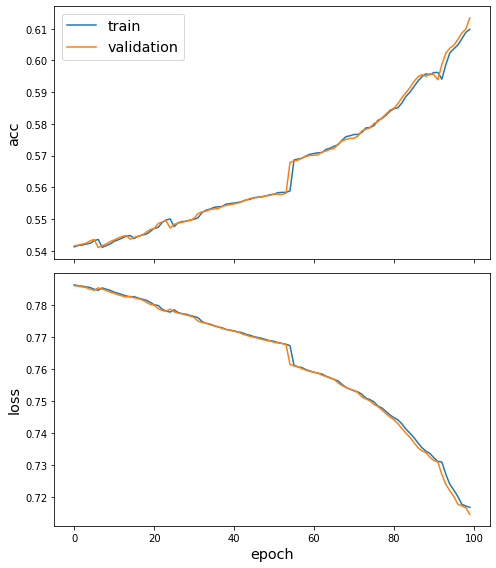

In [ ]:
sg.utils.plot_history(history)

Evaluate the trained model on test interaction links:

In [ ]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 40ms/step - loss: 0.7146 - acc: 0.6134

Train Set Metrics of the trained model:
	loss: 0.7147
	acc: 0.6133

Test Set Metrics of the trained model:
	loss: 0.7146
	acc: 0.6134


In [ ]:
pred = model.predict(test_flow)

1/1 [==============================] - 0s 40ms/step


In [ ]:
def my_func(a):
    if(a>0.5):
      return "Yes"
    else:
      return "No"

actual = np.reshape(edge_labels_test,(342352, 1))
actual = np.apply_along_axis(my_func, 1, actual) 
ex = np.apply_along_axis(my_func, 1, pred[0])
ex

array(['Yes', 'Yes', 'Yes', ..., 'Yes', 'No', 'Yes'], dtype='<U3')

# Prediction
* Yes : There is a link between two given proteins
* No : There is not a link between two given proteins

In [ ]:
df1 = pd.DataFrame(data = edge_ids_test, columns = ["Protein 1","Protein 2"])
df2 = pd.DataFrame(data = actual, columns = ["Actual Value"])
df3 = pd.DataFrame(data = ex, columns = ["Prediction"])
df_predict = pd.concat([df1,df2,df3], axis = 1)

In [ ]:
display(df_predict)

,Protein 1,Protein 2,Actual Value,Prediction
0,5610,9296,Yes,Yes
1,122809,6921,Yes,Yes
2,3875,988,Yes,Yes
3,4541,7384,Yes,Yes
4,199745,79095,Yes,No
...,...,...,...,...
342347,344657,23165,No,Yes
342348,23404,958,No,Yes
342349,186,51181,No,Yes
342350,11023,57704,No,No


## Visualisation of some predicted edges

> Blue : edges from the dataset \\
> Purple : predicted edges



In [34]:
import networkx as nx

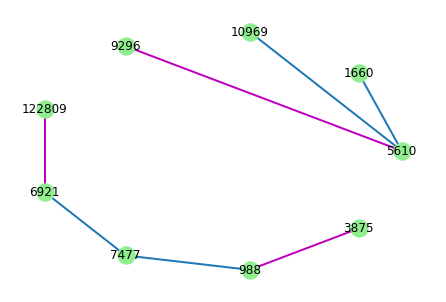

In [33]:
G = nx.Graph()
G.add_edge(5610,1660,color='tab:blue',weight=2)
G.add_edge(5610,10969,color='tab:blue',weight=2)
G.add_edge(5610,9296,color='m',weight=2)
G.add_edge(122809,6921,color='m',weight=2)
G.add_edge(6921,7477,color='tab:blue',weight=2)
G.add_edge(988,7477,color='tab:blue',weight=2)
G.add_edge(988,3875,color='m',weight=2)

colors = nx.get_edge_attributes(G,'color').values()
weights = nx.get_edge_attributes(G,'weight').values()

pos = nx.circular_layout(G)
nx.draw(G, pos, 
        edge_color=colors, 
        width=list(weights),
        with_labels=True,
        node_color='lightgreen')

# References



1.   [Human protein-protein interaction network](https://snap.stanford.edu/biodata/datasets/10000/10000-PP-Pathways.html)
2.   [Large-scale analysis of disease pathways in the human interactome](http://psb.stanford.edu/psb-online/proceedings/psb18/agrawal.pdf)
3.   [stellargraph Link Prediction with GCN](https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/gcn-link-prediction.html)
4.   [Graph Convolutional Prediction of Protein Interactions in Yeast](http://snap.stanford.edu/deepnetbio-ismb/ipynb/Graph+Convolutional+Prediction+of+Protein+Interactions+in+Yeast.html)
5. [Prediction of protein–protein interaction using graph neural networks](https://www.nature.com/articles/s41598-022-12201-9)

